In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import category_encoders
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## data

In [2]:
df_in = pd.read_csv(Path.cwd() / "Fifa 23 Players Data.csv")
df_in.head(1)

,Known As,Full Name,Overall,Potential,Value(in Euro),Positions Played,Best Position,Nationality,Image Link,Age,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,...,91,88,91,67,66,67,62,53,62,22


In [3]:
Y_COLUMN = "Wage(in Euro)"
X_NUMERICAL_COLUMNS = [
    "Overall",
    "Potential",
    "Age",
    "Height(in cm)",
    "Weight(in kg)",
    "Weak Foot Rating",
    "Pace Total",
    "Shooting Total",
    "Passing Total",
    "Dribbling Total",
    "Defending Total",
    "Physicality Total",
    "Crossing",
    "Finishing",
    "Heading Accuracy",
    "Short Passing",
    "Volleys",
    "Dribbling",
    "Curve",
    "Freekick Accuracy",
    "LongPassing",
    "BallControl",
    "Acceleration",
    "Sprint Speed",
    "Agility",
    "Reactions",
    "Balance",
    "Shot Power",
    "Jumping",
    "Stamina",
    "Strength",
    "Long Shots",
    "Aggression",
    "Interceptions",
    "Positioning",
    "Vision",
    "Penalties",
    "Composure",
    "Marking",
    "Standing Tackle",
    "Sliding Tackle",
]
X_CATEGORICAL_COLUMNS = [
    "Best Position",
    "Nationality",
    "Club Position",
    "Club Jersey Number",
    "Preferred Foot",
    "Attacking Work Rate",
    "Defensive Work Rate",
]
df = df_in[X_CATEGORICAL_COLUMNS + X_NUMERICAL_COLUMNS + [Y_COLUMN]].copy()
df[X_CATEGORICAL_COLUMNS] = df[X_CATEGORICAL_COLUMNS].astype("category")
df[X_NUMERICAL_COLUMNS] = df[X_NUMERICAL_COLUMNS].astype(int)
df.head(1)

,Best Position,Nationality,Club Position,Club Jersey Number,Preferred Foot,Attacking Work Rate,Defensive Work Rate,Overall,Potential,Age,...,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Wage(in Euro)
0,CAM,Argentina,RW,30,Left,Low,Low,91,91,35,...,44,40,93,94,75,96,20,35,24,195000


### one hot encoding

In [4]:
encoder = category_encoders.OneHotEncoder(use_cat_names=True)
df_ohe = encoder.fit_transform(df[X_CATEGORICAL_COLUMNS])
df[X_NUMERICAL_COLUMNS] = MinMaxScaler().fit_transform(df[X_NUMERICAL_COLUMNS])
X_num = df[X_NUMERICAL_COLUMNS]
X_ohe = pd.concat([X_num, df_ohe], axis=1)
X_ohe.head(1)

/home/quczer/.local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/home/quczer/.local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/home/quczer/.local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/home/quczer/.local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/home/quczer/.local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: F

,Overall,Potential,Age,Height(in cm),Weight(in kg),Weak Foot Rating,Pace Total,Shooting Total,Passing Total,Dribbling Total,...,Club Jersey Number_53,Club Jersey Number_78,Preferred Foot_Left,Preferred Foot_Right,Attacking Work Rate_Low,Attacking Work Rate_Medium,Attacking Work Rate_High,Defensive Work Rate_Low,Defensive Work Rate_Medium,Defensive Work Rate_High
0,1.0,0.914894,0.678571,0.27451,0.321429,0.75,0.768116,0.960526,0.955882,1.0,...,0,0,1,0,1,0,0,1,0,0


### train-test split

In [5]:
TEST_RATIO = 0.3

X_cat = df[X_CATEGORICAL_COLUMNS + X_NUMERICAL_COLUMNS]
y = df[Y_COLUMN]
split_idx = round(len(X_cat) * (1 - TEST_RATIO))
X_cat_train, X_cat_test = X_cat[:split_idx], X_cat[split_idx:]
X_num_train, X_num_test = X_num[:split_idx], X_num[split_idx:]
X_ohe_train, X_ohe_test = X_ohe[:split_idx], X_ohe[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
X_cat_train.shape, X_ohe_train.shape, X_num_train.shape, y_train.shape, X_cat_test.shape, X_ohe_test.shape, X_num_test.shape, y_test.shape

((12977, 48),
 (12977, 344),
 (12977, 41),
 (12977,),
 (5562, 48),
 (5562, 344),
 (5562, 41),
 (5562,))

## models

In [6]:
class WrappedModel:
    def __init__(
        self, input_type: str, model: BaseEstimator, top_features: int | None = None
    ):
        if input_type not in ["numerical", "one-hot", "categorical"]:
            raise ValueError(f"type {input_type} not supported")
        self.input_type = input_type
        self.model = model
        self.model_type = type(self.model).__name__
        self.top_features = top_features

    def __str__(self):
        prefix = f"{self.model_type} | {self.input_type}"
        if self.top_features:
            return f"{prefix} | top_features={self.top_features}"
        return prefix

    @property
    def name(self):
        return str(self)

    def importances(self):
        if isinstance(self.model, LinearRegression):
            return abs(self.model.coef_)
        else:
            return self.model.feature_importances_

    def __getattr__(self, attr):
        return getattr(self.model, attr)

In [16]:
models = [
    # WrappedModel("one-hot", LinearRegression(positive=False)),
    WrappedModel("numerical", LinearRegression(positive=False)),
    WrappedModel("one-hot", RandomForestRegressor()),
    WrappedModel("one-hot", GradientBoostingRegressor()),
    WrappedModel("numerical", RandomForestRegressor()),
    WrappedModel("numerical", GradientBoostingRegressor()),
    WrappedModel("one-hot", LinearRegression(positive=False), top_features=20),
    WrappedModel("one-hot", LinearRegression(positive=False), top_features=50),
    WrappedModel("one-hot", RandomForestRegressor(), top_features=30),
    WrappedModel("one-hot", GradientBoostingRegressor(), top_features=30),
]

In [17]:
hasattr(models[1], "input_type")

True

## fit and predict

In [18]:
def get_dataset(model_input_type: str, features: list[str] | None = None):
    if model_input_type == "numerical":
        X_train, X_test = X_num_train, X_num_test
    elif model_input_type == "one-hot":
        X_train, X_test = X_ohe_train, X_ohe_test
    elif model_input_type == "categorical":
        X_train, X_test = X_cat_train, X_cat_test

    if features:
        return X_train[features], X_test[features]

    return X_train, X_test

In [19]:
def get_importances_df(model):
    X_train, _ = get_dataset(model.input_type)
    columns = X_train.columns
    df = pd.DataFrame(
        columns=["feature", "score"], data=zip(columns, model.importances())
    )
    return df.sort_values("score", ascending=False)


def get_top_features(model, n):
    imp_df = get_importances_df(model)
    return imp_df["feature"].values[:n]

In [20]:
def train(models):
    results = {}
    for model in models:
        X_train, X_test = get_dataset(model.input_type)
        print(model.name)
        if model.top_features:
            model.fit(X_train, y_train)
            features = get_top_features(model, model.top_features)
        else:
            features = X_train.columns
        results[model.name] = model.fit(X_train[features], y_train).predict(
            X_test[features]
        )
    return results


results = train(models)

LinearRegression | numerical
RandomForestRegressor | one-hot
GradientBoostingRegressor | one-hot
RandomForestRegressor | numerical
GradientBoostingRegressor | numerical
LinearRegression | one-hot | top_features=20
LinearRegression | one-hot | top_features=50
RandomForestRegressor | one-hot | top_features=30
GradientBoostingRegressor | one-hot | top_features=30


## evaluate

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics = [("mse", mean_squared_error), ("mae", mean_absolute_error), ("r2", r2_score)]


def results_to_df(results):
    data = []
    for model_name, y_pred in results.items():
        for metric_name, metric in metrics:
            data.append([model_name, metric_name, metric(y_test, y_pred)])
    res_df = pd.DataFrame(columns=["model", "metric", "score"], data=data)
    return res_df


res_df = results_to_df(results)
res_df.head()

,model,metric,score
0,LinearRegression | numerical,mse,6.988903e+08
1,LinearRegression | numerical,mae,2.390645e+04
2,LinearRegression | numerical,r2,-4.224008e+02
3,RandomForestRegressor | one-hot,mse,2.654130e+06
4,RandomForestRegressor | one-hot,mae,1.270387e+03


<AxesSubplot: xlabel='metric', ylabel='score'>

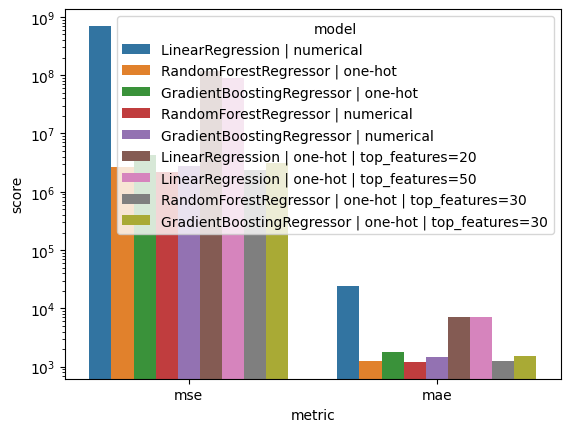

In [34]:
sns.barplot(
    data=res_df[res_df.metric != "r2"], x="metric", y="score", hue="model", log=True
)

<AxesSubplot: xlabel='metric', ylabel='score'>

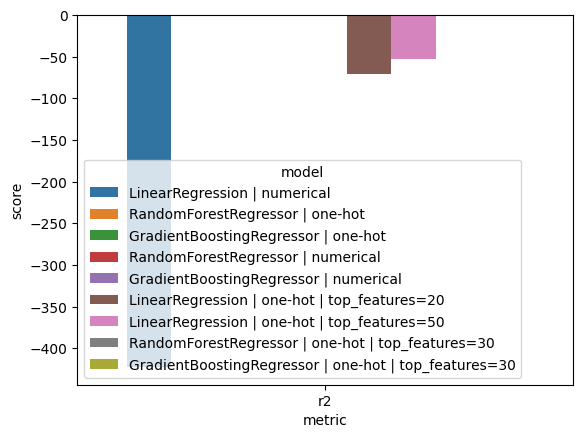

In [46]:
sns.barplot(data=res_df[res_df.metric == "r2"], x="metric", y="score", hue="model")

In [59]:
# rescale losses but not r2
res_scaled_df = res_df.copy()
for metric_name, _ in metrics:
    idx = res_scaled_df.metric == metric_name
    res_scaled_df.loc[idx, "score"] = (
        MinMaxScaler()
        .fit_transform(res_scaled_df.loc[idx, "score"].values[:, None])
        .ravel()
    )

res_scaled_df.groupby(["metric"])["score"].agg(["min", "max"])

,min,max
metric,,
mae,0.0,1.0
mse,0.0,1.0
r2,0.0,1.0


<AxesSubplot: xlabel='metric', ylabel='score'>

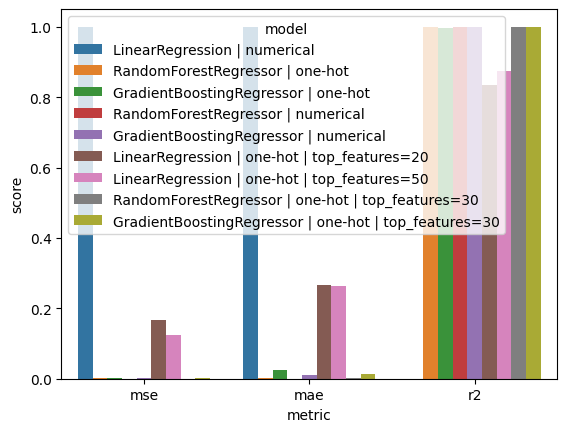

In [60]:
sns.barplot(data=res_scaled_df, x="metric", y="score", hue="model")

In [32]:
r2_score(y_test, [y_test.mean()] * len(y_test))

0.0